# PATH ridership over time

Cleaned + Plotted Port Authority data from https://www.panynj.gov/path/en/about/stats.html

In [1]:
from utz import *
from utz.colors import colors_lengthen
from datetime import timedelta
from ire import export
from path_data.paths import DATA, ALL_PQT
from path_data.utils import mo_str

Papermill parameters:

In [2]:
force = True
default_show = 'png'
W = 1200
H = 600
end_month = None

In [3]:
rename_stations = {
    '9thStreet': '9th Street',
    '14thStreet': '14th Street',
    '23rdStreet': '23rd Street',
    '33rdStreet': '33rd Street',
    'Pavonia/ Newport': 'Newport',
}

In [4]:
df = concat([
    read_parquet(pqt_path)
    for pqt_path in sorted(glob.glob(f'{DATA}/2*.pqt'))
    if fullmatch(r'\d{4}\.pqt', basename(pqt_path))
]).reset_index()
stations = df.station.apply(lambda s: rename_stations.get(s, s))
df['station'] = stations
df = df[~df.station.str.contains('TOTAL')].copy()
df['dt'] = df['month']
df['year'] = df.dt.dt.year
df['month_idx'] = df.dt.dt.month
df

,month,station,avg daily,avg weekday,avg sat,avg sun,avg holiday,total,total weekday,total sat,total sun,total holiday,dt,year,month_idx
0,2012-01-01,Christopher Street,3619,4256,2708,2433,2040,112187,85113,10830,12163,4081,2012-01-01,2012,1
1,2012-01-01,9th Street,4087,4483,3695,3436,2533,126682,89658,14780,17178,5066,2012-01-01,2012,1
2,2012-01-01,14th Street,7370,8768,5346,4730,4041,228483,175369,21384,23648,8082,2012-01-01,2012,1
3,2012-01-01,23rd Street,6374,8345,2924,2563,3096,197597,166895,11698,12813,6191,2012-01-01,2012,1
4,2012-01-01,33rd Street,28586,34797,17350,16716,18627,886167,695937,69398,83578,37254,2012-01-01,2012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,2025-01-01,Journal Square,17550,20814,12252,9254,10478,544062,437085,49006,37016,20955,2025-01-01,2025,1
2663,2025-01-01,Grove Street,13009,15506,9690,6477,6497,403294,325635,38760,25906,12993,2025-01-01,2025,1
2664,2025-01-01,Exchange Place,8768,10932,4904,3411,4479,271799,229581,19616,13644,8958,2025-01-01,2025,1
2665,2025-01-01,Newport,9012,11432,4667,3241,3828,279359,240072,18666,12965,7656,2025-01-01,2025,1


In [5]:
dfs = []
for pqt_path in sorted(glob.glob(f'{DATA}/2*-day-types.pqt')):
    year = fullmatch(r'(?P<y>\d{4})-day-types\.pqt', basename(pqt_path))['y']
    dfs.append(read_parquet(pqt_path).assign(year=int(year)))
day_hists = pd.concat(dfs).reset_index().set_index(['year', 'month'])
day_hists

weekdays  saturdays  sundays  holidays
year month                                        
2012 1            20          4        5         2
     2            20          4        4         1
     3            22          5        4         0
     4            21          4        5         0
     5            22          4        4         1
...              ...        ...      ...       ...
2024 9            20          4        5         1
     10           22          4        4         1
     11           18          5        4         3
     12           21          4        5         1
2025 1            21          4        4         2

[157 rows x 4 columns]

In [6]:
m = (
    df.merge(
        day_hists,
        how='left',
        left_on=['year', 'month_idx'],
        right_index=True,
    )
    .rename(columns={
        'saturdays': 'sats',
        'sundays': 'suns',
    })
    .drop(columns=['year', 'month_idx', 'dt', 'avg daily', 'total'])
)

for k in ['weekday', 'sat', 'sun', 'holiday']:
    tk = f'total {k}'
    ak = f'avg {k}'
    nk = f'{k}s'
    avg = m[tk] / m[nk]
    mask = (abs(avg - m[ak]) < .51) | ((m[nk] == 0) & (m[tk] == 0))
    if not all(mask):
        err(k)
        raise ValueError(m.loc[~mask, [tk, nk, ak]])
    m[ak] = avg

m['weekends'] = m.sats + m.suns
m['total weekend'] = m['total sat'] + m['total sun']
m['avg weekend'] = m['total weekend'] / m['weekends']

cols = ['month', 'station'] + [
    p+k+s
    for p, s in [('total ', ''), ('avg ', ''), ('', 's')]
    for k in ['weekday', 'weekend', 'sat', 'sun', 'holiday']
]
cols += [ c for c in m if c not in cols ]
m = m[cols]
for c in m:
    if m[c].dtype == np.int64:
        m[c] = m[c].astype('int32')
m

,month,station,total weekday,total weekend,total sat,total sun,total holiday,avg weekday,avg weekend,avg sat,avg sun,avg holiday,weekdays,weekends,sats,suns,holidays
0,2012-01-01,Christopher Street,85113,22993,10830,12163,4081,4255.650000,2554.777778,2707.50,2432.60,2040.5,20,9,4,5,2
1,2012-01-01,9th Street,89658,31958,14780,17178,5066,4482.900000,3550.888889,3695.00,3435.60,2533.0,20,9,4,5,2
2,2012-01-01,14th Street,175369,45032,21384,23648,8082,8768.450000,5003.555556,5346.00,4729.60,4041.0,20,9,4,5,2
3,2012-01-01,23rd Street,166895,24511,11698,12813,6191,8344.750000,2723.444444,2924.50,2562.60,3095.5,20,9,4,5,2
4,2012-01-01,33rd Street,695937,152976,69398,83578,37254,34796.850000,16997.333333,17349.50,16715.60,18627.0,20,9,4,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,2025-01-01,Journal Square,437085,86022,49006,37016,20955,20813.571429,10752.750000,12251.50,9254.00,10477.5,21,8,4,4,2
2663,2025-01-01,Grove Street,325635,64666,38760,25906,12993,15506.428571,8083.250000,9690.00,6476.50,6496.5,21,8,4,4,2
2664,2025-01-01,Exchange Place,229581,33260,19616,13644,8958,10932.428571,4157.500000,4904.00,3411.00,4479.0,21,8,4,4,2
2665,2025-01-01,Newport,240072,31631,18666,12965,7656,11432.000000,3953.875000,4666.50,3241.25,3828.0,21,8,4,4,2


In [7]:
m.dtypes

month            datetime64[ns]
station                  object
total weekday             int32
total weekend             int32
total sat                 int32
total sun                 int32
total holiday             int32
avg weekday             float64
avg weekend             float64
avg sat                 float64
avg sun                 float64
avg holiday             float64
weekdays                  int32
weekends                  int32
sats                      int32
suns                      int32
holidays                  int32
dtype: object

In [8]:
if force or not exists(ALL_PQT):
    (
        m
        # Converting `month`s to `Timestamp`s introduces timezone issues.
        # Save as string, webapp parses and creates localized date in user's timezone.
        .assign(month=m.month.apply(mo_str))
        .to_parquet(ALL_PQT, index=False, engine='fastparquet')
    )

In [9]:
station_hist = stations.value_counts()
station_hist

station
Christopher Street     157
Harrison               157
NEW JERSEY SUBTOTAL    157
Hoboken                157
Newport                157
Exchange Place         157
Grove Street           157
Journal Square         157
Newark                 157
9th Street             157
NEW YORK SUBTOTAL      157
WTC                    157
UPTOWN SUBTOTAL        157
33rd Street            157
23rd Street            157
14th Street            157
MONTHLY TOTAL          157
Name: count, dtype: int64

In [10]:
assert len(station_hist.value_counts()) == 1

In [11]:
if not default_show:
    default_show = None

if end_month is None:
    end_month = (df.month.max() + pd.Timedelta('32d')).strftime('%Y-%m')
end_month

'2025-02'

In [12]:
mt = m.drop(columns='station').groupby('month').sum()
month_dt = to_dt(mt.index.to_series())
months = month_dt.dt
month_idxs = months.month.rename('month_idx')
years = months.year.rename('year')
mt = sxs(years, month_idxs, mt)
mt

,year,month_idx,total weekday,total weekend,total sat,total sun,total holiday,avg weekday,avg weekend,avg sat,avg sun,avg holiday,weekdays,weekends,sats,suns,holidays
month,,,,,,,,,,,,,,,,,
2012-01-01,2012,1,5055387,859750,428830,430920,213096,252769.350000,95527.777778,107207.50,86184.00,106548.000000,260,117,52,65,26
2012-02-01,2012,2,5229454,805942,459565,346377,116023,261472.700000,100742.750000,114891.25,86594.25,116023.000000,260,104,52,52,13
2012-03-01,2012,3,5935471,1017669,649878,367791,0,269794.136364,113074.333333,129975.60,91947.75,0.000000,286,117,65,52,0
2012-04-01,2012,4,5474674,970803,529898,440905,0,260698.761905,107867.000000,132474.50,88181.00,0.000000,273,117,52,65,0
2012-05-01,2012,5,5747143,915369,517147,398222,91973,261233.772727,114421.125000,129286.75,99555.50,91973.000000,286,104,52,52,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,2024,9,4130852,910744,471721,439023,79429,206542.600000,101193.777778,117930.25,87804.60,79429.000000,260,117,52,65,13
2024-10-01,2024,10,4653551,873403,497227,376176,149920,211525.045455,109175.375000,124306.75,94044.00,149920.000000,286,104,52,52,13
2024-11-01,2024,11,3556226,931836,570891,360945,335899,197568.111111,103537.333333,114178.20,90236.25,111966.333333,234,117,65,52,39


In [13]:
from calendar import month_abbr
pivoted = (
    mt
    .assign(month=mt.month_idx.apply(lambda m: month_abbr[m]))
    .set_index(['month_idx', 'month'])
    [['year', 'avg weekday', 'avg weekend', 'avg sat', 'avg sun']]
    .pivot(columns='year')
    .replace(nan, 0).astype(int)
    .sort_index()
    .reset_index(level=0, drop=True)
)
pivoted

avg weekday                                                          \
year         2012    2013    2014    2015    2016    2017    2018    2019   
month                                                                       
Jan        252769  217345  231473  227562  250484  266846  266614  272332   
Feb        261472  233633  233110  245224  259236  266277  279693  278047   
Mar        269794  235594  248144  250488  265131  266744  264986  281604   
Apr        260698  248688  252737  258354  270124  289351  284283  285930   
May        261233  249228  255112  264329  271904  284091  291747  289413   
Jun        265072  252261  259001  267051  277946  288215  291075  292315   
Jul        265127  250018  258038  267492  272799  297494  281776  288163   
Aug        256278  245527  250156  259294  269440  296998  275442  281488   
Sep        267479  256737  258150  269041  278139  293421  289128  298519   
Oct        233818  259234  262365  274483  276417  297031  299787  296976   
Nov        121495  252038  253715  268329  277473  291557  287651  290129   
Dec        185834  233063  237435  248434  258947  265518  258220  257958   

                                                      avg weekend          \
year     2020    2021    2022    2023    2024    2025        2012    2013   
month                                                                       
Jan    277233   56903   84185  145635  161765  178194       95527   71793   
Feb    282850   52604  113247  150237  171388       0      100742   76569   
Mar    126408   64331  132440  155238  177645       0      113074   99111   
Apr     14596   70156  135338  161954  182180       0      107867  105665   
May     20444   79652  140301  171363  192651       0      114421  101889   
Jun     34366   91755  148026  164559  193163       0      116769  109825   
Jul     47028   99230  138957  162386  183297       0      109675  101328   
Aug     54123   98422  138503  162576  175681       0      112315  109007   
Sep     62650  113597  157981  178947  206542       0      117874  109077   
Oct     65840  124726  158481  185147  211525       0      114902  109496   
Nov     61753  128093  155525  176612  197568       0       43762   99845   
Dec     55354  112666  139596  160300  181903       0       69253  103426   

                                                                            \
year     2014    2015    2016    2017    2018    2019   2020   2021   2022   
month                                                                        
Jan     82017   78582   77728   86784   85624   73360  74502  30711  42657   
Feb     94184   82078   89792   95271   88136   81987  82704  32741  60742   
Mar     92322   92510  101323   92523  103004   87886  36523  40567  64200   
Apr     97936  106301  104505  107946  103954   96567   6935  44541  74555   
May    101516  107425  101677  101781  100586   97908  10890  50144  71893   
Jun    101137  107011  107583  111427  110271  101675  18901  65780  82836   
Jul     95779  104194  101454  106582   91841   90233  25766  65199  75270   
Aug     93827  107570   87769  107192   88645   98576  30634  59511  77924   
Sep     96405  109970   96232  111447   96500  101704  38916  73652  86047   
Oct     95562  110087   88010  107386   89490   96709  41378  74408  82763   
Nov     89673  102265   91880  101310  100140   93908  35455  73318  80946   
Dec    101366  111703   90492  103127  111745  107069  31694  66333  73964   

                            avg sat                                          \
year    2023    2024   2025    2012    2013    2014    2015    2016    2017   
month                                                                         
Jan    69585   64782  78153  107207   81710   91282   88873   87875   97009   
Feb    69142   75690      0  114891   83702  109728   94726  102088  110189   
Mar    74664   79578      0  129975  118285  110695  107723  119979  107588   
Apr    77751   92338      0  132474  122783  1127

In [14]:
import plotly.express as px
from IPython.display import Image

In [15]:
gridcolor = '#ddd'

def default_plot(fig, hoverformat=','):
    return (
        fig
        .update_layout(
            title_x=0.5,
            paper_bgcolor='white',
            plot_bgcolor='white',
            legend=dict(traceorder='reversed'),
            hovermode='x',
        ).update_xaxes(
            tickangle=-45,
            gridcolor=gridcolor,
        ).update_traces(
            hovertemplate=None,
        ).update_yaxes(
            gridcolor=gridcolor,
            hoverformat=hoverformat,
        )
    )

In [16]:
def stations_stack(
    y, title, name=None,
    start=None, end=None,
    dtick=None, tickangle=-45,
    width=W, height=H,
    show=default_show,
):
    if isinstance(start, str):
        start = to_dt(start)
    start = start or to_dt('2012')
    start -= timedelta(days=15)
    if isinstance(end, str):
        end = to_dt(end)
    end = end or to_dt(end_month)
    end -= timedelta(days=15)
    dims = dict(width=width, height=height)
    fig = default_plot(
        px.bar(
            m.reset_index(),
            x='month', y=y, color='station',
            title=title,
            labels={
                'station': 'Station',
                y: title,
                'month': '',
            }
        )
    ).update_xaxes(
        range=[start, end],
        dtick=dtick,
    ).update_layout(**dims)
    if name:
        path = f'img/{name}.png'
        print(f'Saving {path}')
        fig.write_image(path, **dims)
    return export(fig, name, show=show)

In [17]:
num_years = len(mt.year.unique())
num_years

14

In [18]:
px_colors = px.colors.sequential.Inferno
colors = list(reversed(colors_lengthen(px_colors, num_years)))
colors

['#fcffa4',
 '#f8df5c',
 '#f8bc27',
 '#f99708',
 '#f0741d',
 '#df5734',
 '#c8404a',
 '#ab2f5b',
 '#8c2367',
 '#6d186c',
 '#4d0d6b',
 '#2d0c51',
 '#12082e',
 '#000004']

In [19]:
month_names = [ to_dt('2022-%02d' % i).strftime('%b') for i in range(1, 13) ]
print(' '.join(month_names))

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec


In [20]:
def grouped_month_plot(y, title, width=W, height=H, show=default_show):
    fig = px.bar(
        mt,
        x='month_idx', y=y,
        color=mt.year.astype(str),
        color_discrete_sequence=colors,
        labels={
            'color': 'Year',
            'month_idx': '',
            y: title,
        },
        barmode='group',
    )
    dims = dict(width=width, height=height)
    fig = fig.update_layout(
        title=f'{title} (grouped by month)',
        title_x=0.5,
        xaxis=dict(
            tickmode = 'array',
            tickvals = list(range(1, 13)),
            ticktext = month_names,
        ),
        **dims,
    )
    name = f'{y}_month_grouped.png'
    path = f'img/{name}'
    fig.write_image(path, **dims)
    return export(fig, name, show=show)

# Weekdays

Saving img/weekdays.png


Saved plotly to .ire/weekdays.json


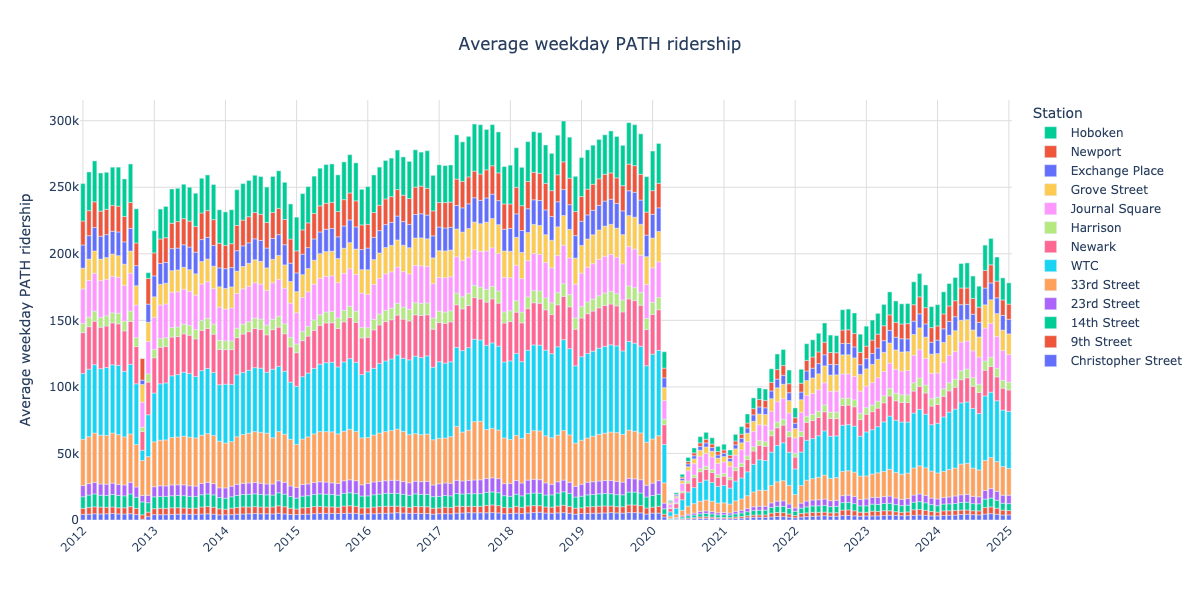

In [21]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership',
    dtick="M12",
    name='weekdays',
)

Saving img/weekdays_2020:.png


Saved plotly to .ire/weekdays_2020:.json


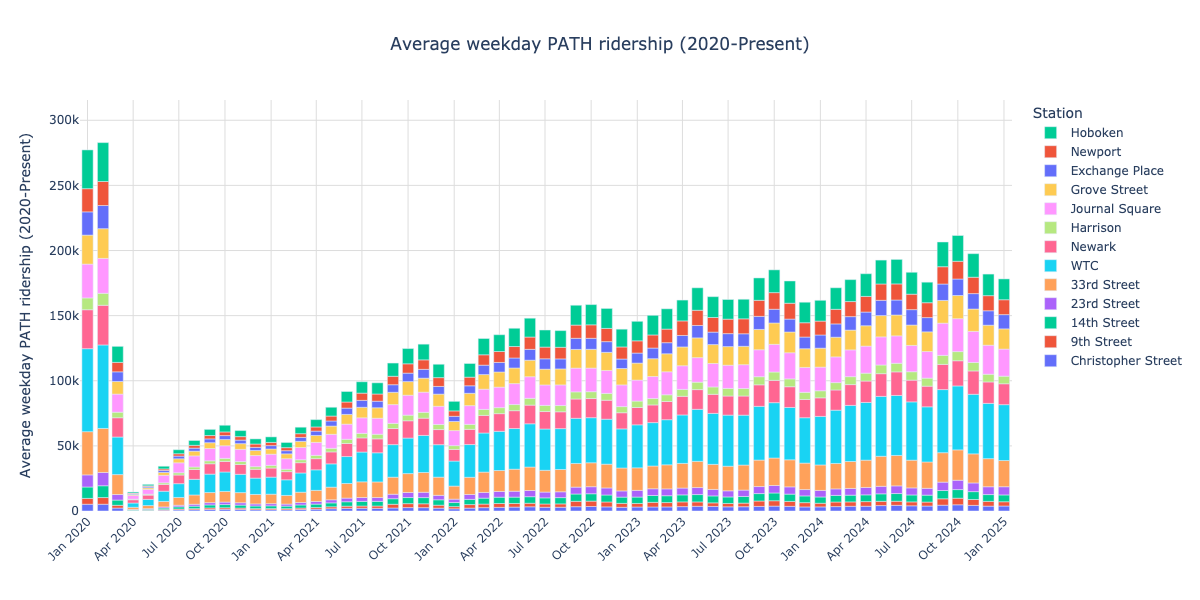

In [22]:
stations_stack(
    'avg weekday',
    'Average weekday PATH ridership (2020-Present)',
    name='weekdays_2020:',
    dtick='M3',
    start='2020',
)

Saved plotly to .ire/avg weekday_month_grouped.png.json


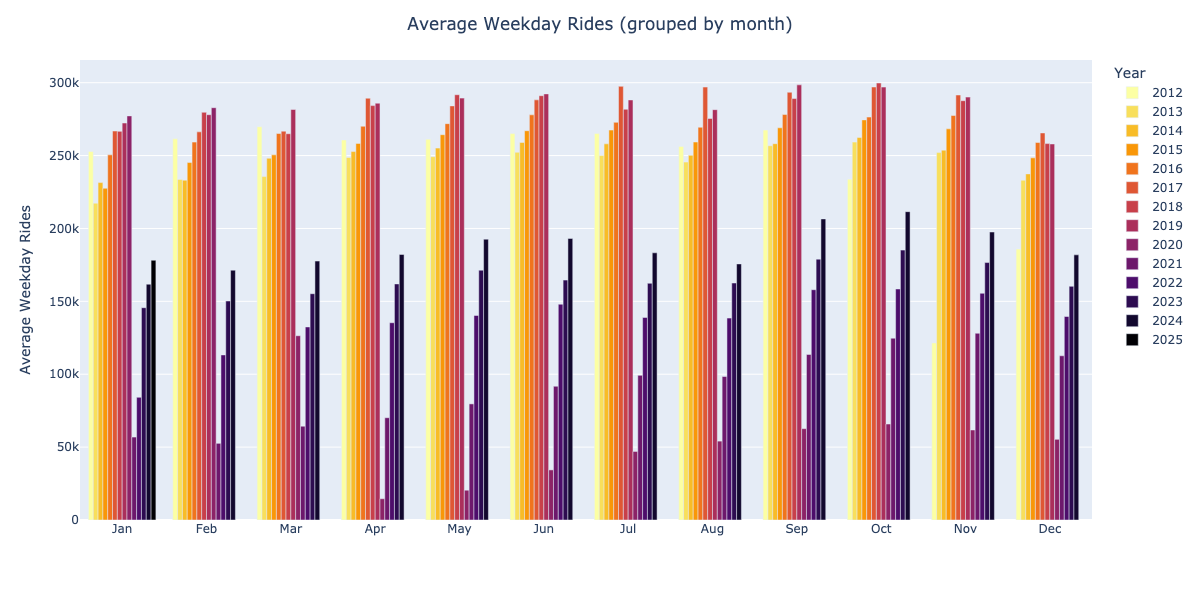

In [23]:
grouped_month_plot('avg weekday', 'Average Weekday Rides')

# Weekends

Saving img/weekends.png


Saved plotly to .ire/weekends.json


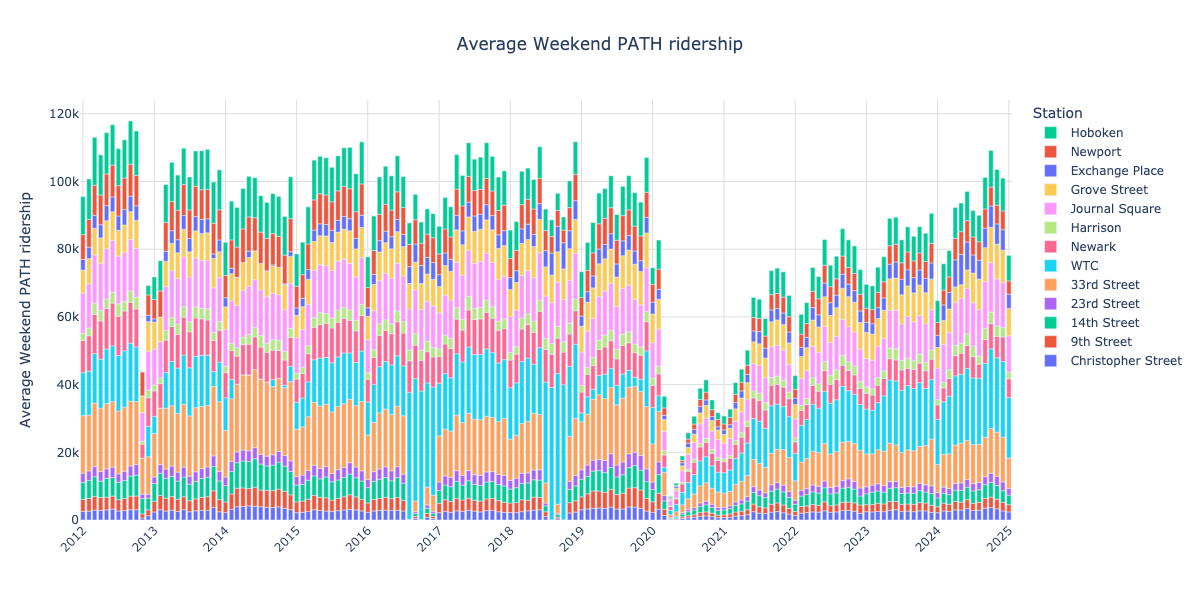

In [24]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership',
    dtick="M12",
    name='weekends',
)

Saving img/weekends_2020:.png


Saved plotly to .ire/weekends_2020:.json


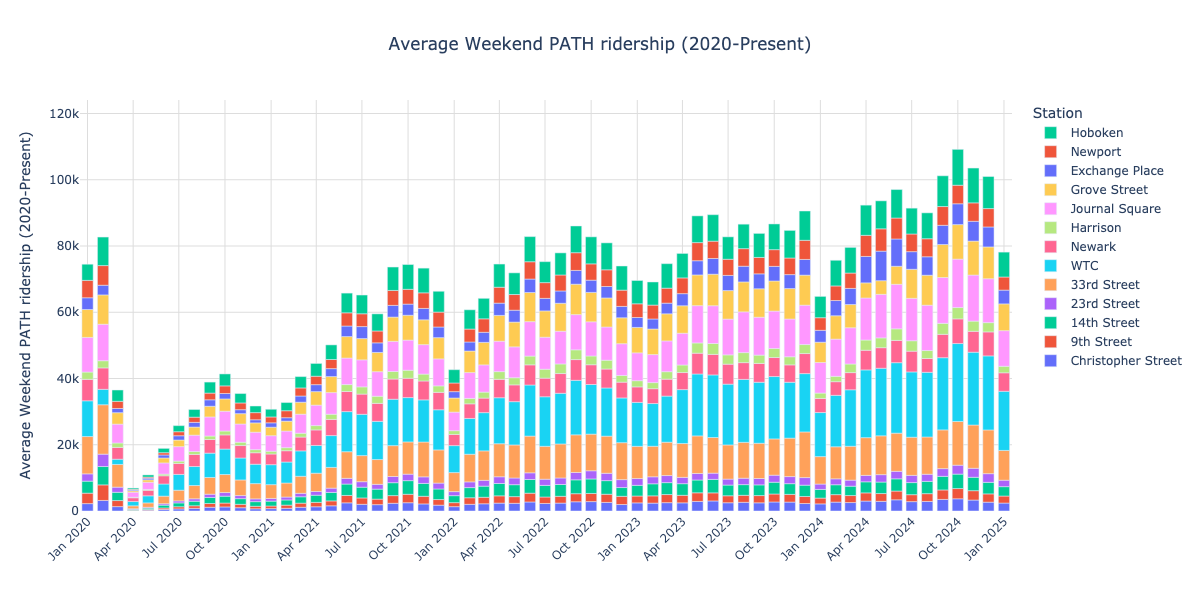

In [25]:
stations_stack(
    'avg weekend',
    'Average Weekend PATH ridership (2020-Present)',
    dtick="M3",
    name='weekends_2020:',
    start='2020',
)

Saved plotly to .ire/avg weekend_month_grouped.png.json


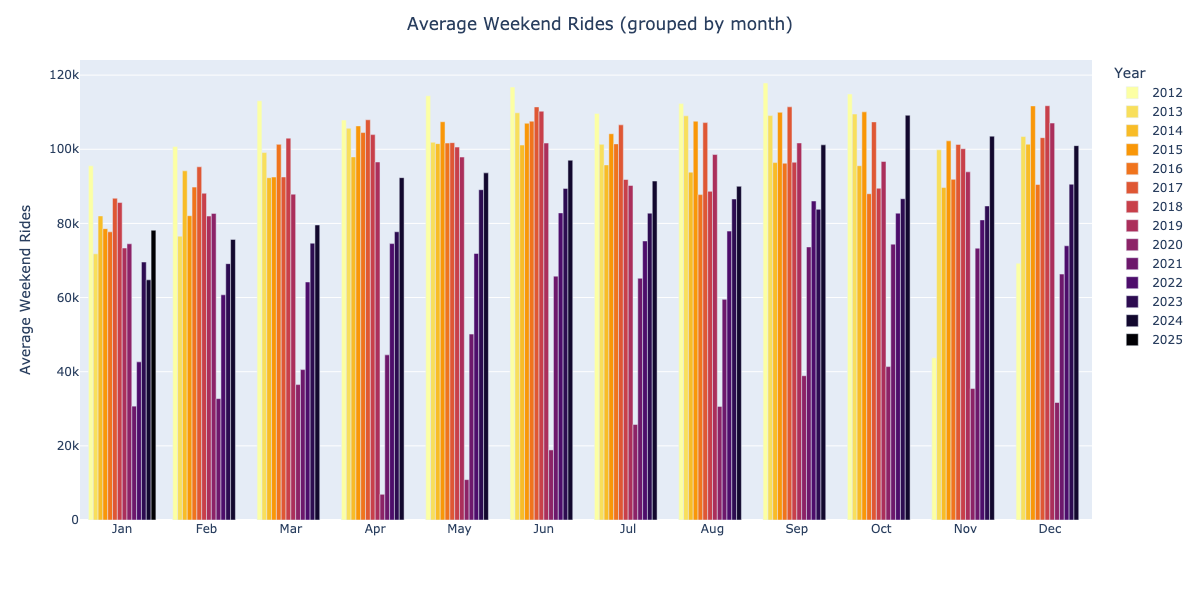

In [26]:
grouped_month_plot('avg weekend', 'Average Weekend Rides')

# Combined

## Average Daily PATH Ridership <a id="avg-daily"></a>

In [27]:
def lines(
    df, name, xname, y_fmt,
    hoverx=True, dir='img',
    legend_lr=False,
    ax_offset=None,
    ay_offsets=None,
    h_line=None,
    xtick=None, xtickformat=None,
    ytick=None, ytickformat=None,
    show=default_show,
    w=1000, h=600,
    **kwargs,
):
    fig = px.line(
        df,
        labels={
            'variable': '',
            'value': xname,
            'month': '',
        }
    )
    idx = df.index.to_series()
    for k, ay_offset in zip(df, ay_offsets):
        x = idx.iloc[-1]
        y = df[k].iloc[-1]
        x_str = x.strftime("%b '%y")
        y_str = format(y, y_fmt)
        fig.add_annotation(
            x=x,
            ax=idx.iloc[-ax_offset],
            axref="x",
            y=y, ayref="y", ay=y + ay_offset,
            text=f'{x_str}: {y_str}',
        )
    if h_line is not None:
        fig.add_hline(y=h_line, line=dict(color='#777', width=1)),
    fig = plots.save(
        fig,
        name=name,
        x=dict(dtick=xtick, tickformat=xtickformat),
        y=dict(dtick=ytick, tickformat=ytickformat),
        legend=(
            dict(
                yanchor="bottom",
                y=0.03,
                xanchor="right",
                x=0.99,
            ) if legend_lr else dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99,
            )
        ),
        hoverx=hoverx,
        dir=dir,
        w=w, h=h,
        **kwargs,
    )
    return export(fig, name, show=show)

Wrote plot JSON to img/avg_day_types.json
Wrote plot image to img/avg_day_types.png
Saved plotly to .ire/avg_day_types.json


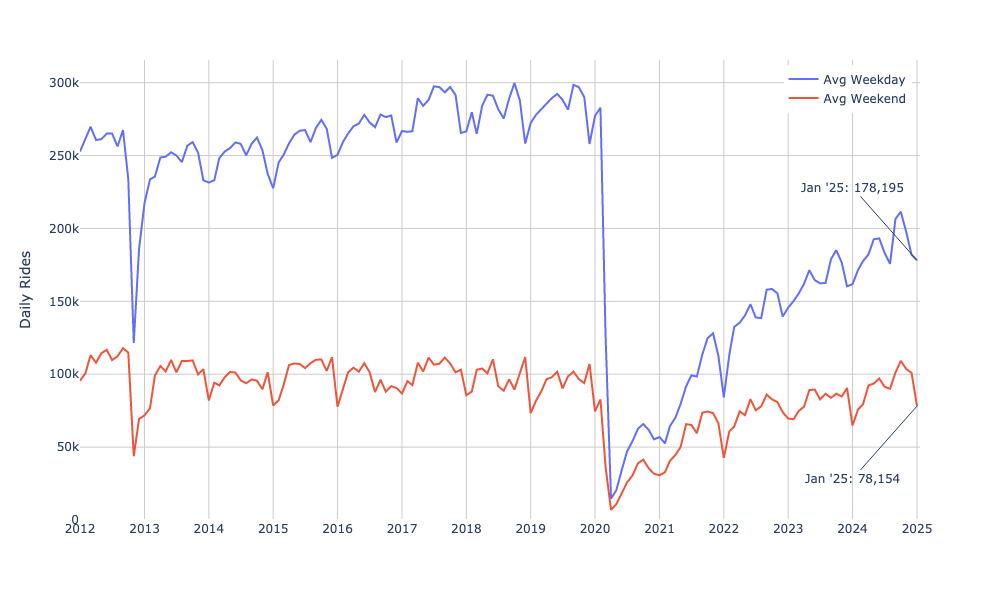

In [28]:
lines(
    mt[['avg weekday', 'avg weekend',]].rename(columns={
        'avg weekday': 'Avg Weekday',
        'avg weekend': 'Avg Weekend',
    }),
    name='avg_day_types',
    xname = 'Daily Rides',
    xtick = "M12",
    hovertemplate='%{y:,.0f}',
    y_fmt = ',.0f',
    ax_offset=13, ay_offsets=[50_000, -50_000],
    legend_lr=False,
)

## 2020-2022 Ridership vs. 2019

In [29]:
mt20 = mt[month_dt >= to_dt('2020')]
mt19 = mt[mt.year == 2019]
mt19s = pd.concat([ mt19 for i in range((len(mt20) + len(mt19) - 1) // len(mt19)) ]).iloc[:len(mt20)]

keys = ['avg weekday', 'avg weekend']
cmp19 = (
    sxs(
        mt19s.reset_index(drop=True)[keys].rename(columns={ key: f'{key} 2019' for key in keys }),
        mt20.reset_index()[keys + ['month']],
    )
    .set_index('month')
)
for k in keys:
    cmp19[f'{k} frac'] = cmp19[k] / cmp19[f'{k} 2019']
cmp19

,avg weekday 2019,avg weekend 2019,avg weekday,avg weekend,avg weekday frac,avg weekend frac
month,,,,,,
2020-01-01,272332.142857,73360.000000,277233.571429,74502.625000,1.017998,1.015576
2020-02-01,278047.157895,81987.375000,282850.210526,82704.000000,1.017274,1.008741
2020-03-01,281604.857143,87886.600000,126408.681818,36523.000000,0.448887,0.415570
2020-04-01,285930.000000,96567.625000,14596.500000,6935.375000,0.051049,0.071819
2020-05-01,289413.181818,97908.125000,20444.700000,10890.800000,0.070642,0.111235
2020-06-01,292315.800000,101675.800000,34366.409091,18901.625000,0.117566,0.185901
2020-07-01,288163.136364,90233.125000,47028.409091,25766.375000,0.163201,0.285553
2020-08-01,281488.590909,98576.666667,54123.523810,30634.900000,0.192276,0.310772
2020-09-01,298519.000000,101704.666667,62650.809524,38916.625000,0.209872,0.382643


## PATH Ridership: 2020-2023 (YTD) vs. 2019 <a id="vs-2019"></a>

Wrote plot JSON to img/vs_2019.json
Wrote plot image to img/vs_2019.png
Saved plotly to .ire/vs_2019.json


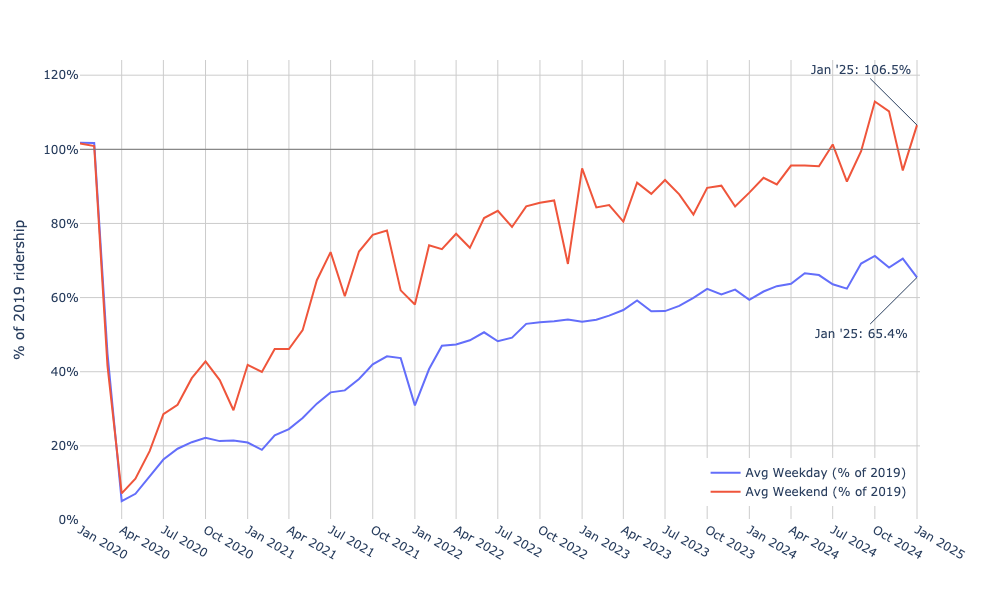

In [30]:
lines(
    cmp19[[f'{k} frac' for k in keys]].rename(columns={
        'avg weekday frac': 'Avg Weekday (% of 2019)',
        'avg weekend frac': 'Avg Weekend (% of 2019)',
    }),
    name='vs_2019',
    xname='% of 2019 ridership',
    xtick="M3",
    ytickformat=".0%",
    ax_offset=5, ay_offsets=[-.15, .15],
    h_line=1,
    hovertemplate='%{y:.1%}',
    y_fmt='.1%',
    legend_lr=True,
)

# {Month,Station} data

In [31]:
export(df.set_index(['month', 'station']), 'path', fmts={'month': "%b '%y"}, per_page=20);

Saved parquet to .ire/path.parquet
